#### Example of text classification with Keras NN which embedding layer is generated by word2vec

Reference pages:
- https://realpython.com/python-keras-text-classification/#convolutional-neural-networks-cnn
- https://machinelearningmastery.com/how-to-calculate-precision-recall-f1-and-more-for-deep-learning-models/

The dataset was preprocessed in **finance complaints dataset analysis** notebook.

Loading balanced dataset.

In [94]:
import pandas as pd
df = pd.read_csv('complaints-balanced.csv')
print(df.isnull().sum())
df.head()

Unnamed: 0                      0
Product                         0
Consumer_complaint_narrative    0
category_id                     0
dtype: int64


,Unnamed: 0,Product,Consumer_complaint_narrative,category_id
0,0,"Credit reporting, credit repair services, or o...",These aren't mine ... please remove it.,0
1,1,"Credit reporting, credit repair services, or o...",XXXX and Transunion are incorrectly reporting ...,0
2,2,"Credit reporting, credit repair services, or o...",I have been disputing a derogatory mark on my ...,0
3,3,"Credit reporting, credit repair services, or o...",I have sent 3 letters to all 3 credit bureau '...,0
4,4,"Credit reporting, credit repair services, or o...",ive been working back and forth calling emaili...,0


Text preprocessing

In [95]:
%%time
import re

text = df.Consumer_complaint_narrative
# removing numbers
text = text.apply(lambda x: re.sub(r'\d+', '', x))

# removing XXX words
text = text.apply(lambda x: re.sub(r'X*', '', x))

# converting to lower case
text = text.apply(lambda x: x.lower())

text.head()

CPU times: user 1.35 s, sys: 3.66 ms, total: 1.35 s
Wall time: 1.35 s


0              these aren't mine ... please remove it.
1     and transunion are incorrectly reporting me a...
2    i have been disputing a derogatory mark on my ...
3    i have sent  letters to all  credit bureau 's,...
4    ive been working back and forth calling emaili...
Name: Consumer_complaint_narrative, dtype: object

Creating train and test sets, with balanced frequency of classes.

In [96]:
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils

# encoding labels to one hot vectors
encoder = LabelEncoder()
encoder.fit(df['category_id'])
encoded_Y = encoder.transform(df['category_id'])
Y = np_utils.to_categorical(encoded_Y)

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=0)
for train_index, test_index in sss.split(text, Y):
    train_sentences = text.loc[train_index]
    Y_train = Y[train_index]
    test_sentences = text.loc[test_index]
    test_labels = df['category_id'].loc[test_index]
    Y_test = Y[test_index]

**Preparing the inputs**

The `Tokenizer` utility class which can vectorize a text corpus into a list of integers. Each integer maps to a value in a dictionary that encodes the entire corpus, with the keys in the dictionary being the vocabulary terms themselves. We can add the parameter `num_words`, which is responsible for setting the size of the vocabulary. The most common `num_words` words will be then kept.

In [97]:
%%time
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_sentences)

X_train = tokenizer.texts_to_sequences(train_sentences)
X_test = tokenizer.texts_to_sequences(test_sentences)

# Adding 1 because of reserved 0 index
vocab_size = len(tokenizer.word_index) + 1

CPU times: user 1.07 s, sys: 1.39 ms, total: 1.07 s
Wall time: 1.08 s


The indexing is ordered after the most common words in the text. It is important to note that the index 0 is reserved and is not assigned to any word. This zero index is used for padding, which will be done in a moment.

Unknown words (words that are not in the vocabulary) are denoted in Keras with word_count + 1 since they can also hold some information. You can see the index of each word by taking a look at the `word_index` dictionary of the `Tokenizer` object.

In [98]:
for word in ['the', 'all', 'happy', 'sad']:
    print('{}: {}'.format(word, tokenizer.word_index[word]))

the: 1
all: 48
happy: 1437
sad: 3817


With Tokenizer, the resulting vectors equal the length of each text, and the resulting vectors won't have the same length. To counter this, you can use `pad_sequence()` which simply pads the sequence of words with zeros. By default, it prepends zeros but we will to append them. Additionally you would want to add a `maxlen` parameter to specify how long the sequences should be. This cuts sequences that exceed that number.

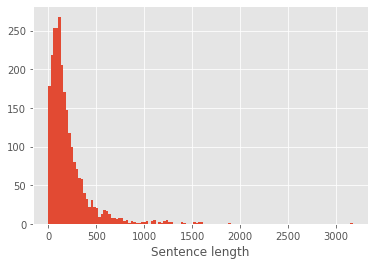

In [99]:
import matplotlib.pyplot as plt

# analyzing the sentences' length
freqs = pd.Series(X_train).apply(lambda x: len(x))
plt.hist(freqs, bins='auto') 
plt.xlabel('Sentence length');

In [100]:
from keras.preprocessing.sequence import pad_sequences

max_len = 450

X_train = pad_sequences(X_train, padding='post', maxlen=max_len)
X_test = pad_sequences(X_test, padding='post', maxlen=max_len)

**Training word2vec**

In [101]:
%%time
from keras.preprocessing.text import text_to_word_sequence

# for word2vec
w2v_input = []
for s in train_sentences:
    w2v_input.append(text_to_word_sequence(s))

CPU times: user 154 ms, sys: 0 ns, total: 154 ms
Wall time: 153 ms


In [102]:
%%time
import gensim

embedding_dim = 200
word_model = gensim.models.Word2Vec(w2v_input, 
                                    size=embedding_dim, 
                                    iter=10)

CPU times: user 17 s, sys: 84.2 ms, total: 17.1 s
Wall time: 7.08 s


**Creating and traning the model**

We can use the Embedding Layer of Keras to store the vectors calculated by word2vec.

After the embedding layer, we will apply a MaxPooling1D/AveragePooling1D or a pooling layer (`GlobalMaxPooling1D` or `GlobalAveragePooling1D`).

In the case of max pooling, you take the maximum value of all features in the pool for each feature dimension. In the case of average pooling, you take the average, but max pooling seems to be more commonly used as it highlights large values.

Global max/average pooling takes the maximum/average of all features whereas in the other case you have to define the pool size. Keras has again its own layer that you can add in the sequential model.

In [103]:
from keras import layers

word_index = tokenizer.word_index

embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in word_index.items():
    if word in word_model.wv.vocab:
        embedding_matrix[i] = word_model.wv.get_vector(word)
        
print('Null word embeddings: %d' % np.sum(np.sum(embedding_matrix, axis=1) == 0))

embedding_layer = layers.Embedding(embedding_matrix.shape[0], # or len(word_index) + 1
                            embedding_matrix.shape[1], # or EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=max_len,
                            trainable=True)

Null word embeddings: 6353


In [104]:
from keras.models import Sequential

model = Sequential()
model.add(embedding_layer)
model.add(layers.GlobalMaxPool1D())
model.add(layers.Dense(10, 
                       activation='relu'))
model.add(layers.Dense(5, 
                       activation='sigmoid'))
model.compile(optimizer='adam', 
              loss='binary_crossentropy', 
              metrics=['categorical_accuracy'])
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 450, 200)          2092800   
_________________________________________________________________
global_max_pooling1d_7 (Glob (None, 200)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 10)                2010      
_________________________________________________________________
dense_14 (Dense)             (None, 5)                 55        
Total params: 2,094,865
Trainable params: 2,094,865
Non-trainable params: 0
_________________________________________________________________


Training the model.

In [105]:
%%time
history = model.fit(X_train, 
                    Y_train,
                    epochs=40,
                    verbose=False,
                    validation_data=(X_test, Y_test),
                    batch_size=5)

/home/alexandre/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


CPU times: user 29min 44s, sys: 17min 20s, total: 47min 5s
Wall time: 12min 8s


Evaluation.

Training Accuracy: 0.9209
Testing Accuracy:  0.7424


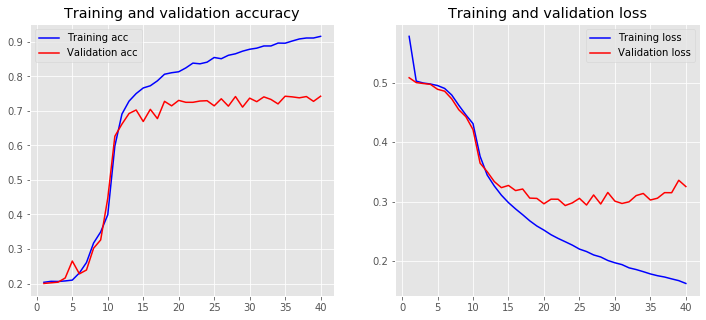

In [106]:
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['categorical_accuracy']
    val_acc = history.history['val_categorical_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

loss, accuracy = model.evaluate(X_train, 
                                Y_train, 
                                verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))

loss, accuracy = model.evaluate(X_test, 
                                Y_test, 
                                verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

plot_history(history)

In [107]:
from sklearn.metrics import accuracy_score, confusion_matrix

my_tags = df.category_id.unique()
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(my_tags))
    target_names = my_tags
    plt.xticks(tick_marks, target_names, rotation=45)
    plt.yticks(tick_marks, target_names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def evaluate_prediction(predictions, target, title="Confusion matrix"):
    print('accuracy %s' % accuracy_score(target, predictions))
    cm = confusion_matrix(target, predictions, labels=my_tags)
    print('confusion matrix\n %s' % cm)
    print('(row=expected, col=predicted)')
    
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plot_confusion_matrix(cm_normalized, title + ' Normalized')

accuracy 0.742354031510658
confusion matrix
 [[154  29  16  15   2]
 [ 34 148  19   7   8]
 [ 16  19 117  25  38]
 [  0   2  11 200   3]
 [  1   6  14  13 182]]
(row=expected, col=predicted)
              precision    recall  f1-score   support

           0       0.75      0.71      0.73       216
           1       0.73      0.69      0.70       216
           2       0.66      0.54      0.60       215
           3       0.77      0.93      0.84       216
           4       0.78      0.84      0.81       216

    accuracy                           0.74      1079
   macro avg       0.74      0.74      0.74      1079
weighted avg       0.74      0.74      0.74      1079



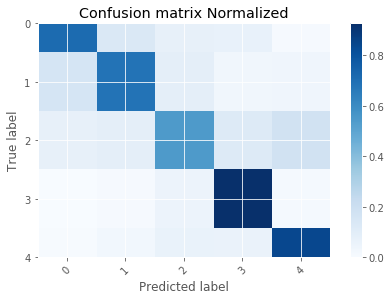

In [108]:
from sklearn import metrics

Y_pred = model.predict(X_test, 
                       verbose=0)
evaluate_prediction(Y_pred.argmax(axis=1), 
                    Y_test.argmax(axis=1))

print(metrics.classification_report(Y_test.argmax(axis=1), 
                                    Y_pred.argmax(axis=1)))